# 导入数据，预处理

In [1]:
import os, codecs
import pandas as pd
import numpy as np
import geopandas as gpd 
import transbigdata as tbd


PATH = '/Users/jerseylu/Downloads/bike-sharing/DCIC2021/'

# 共享单车轨迹数据
df_track = pd.concat([
    pd.read_csv(PATH + 'gxdc_gj20201221.csv'),
    pd.read_csv(PATH + 'gxdc_gj20201222.csv'),
    pd.read_csv(PATH + 'gxdc_gj20201223.csv'), # rainy day
    pd.read_csv(PATH + 'gxdc_gj20201224.csv'),
    pd.read_csv(PATH + 'gxdc_gj20201225.csv')

])

# 按照单车ID和时间进行排序
df_track = df_track.sort_values(['BICYCLE_ID', 'LOCATING_TIME'])

In [2]:
def df_fence_format(s):
    s = s.replace('[', '').replace(']', '').split(',')
    s = np.array(s).astype(float).reshape(5, -1)
    return s

# 共享单车停车点位（电子围栏）数据
df_fence = pd.read_csv(PATH + 'gxdc_tcd.csv')
df_fence['FENCE_LOC'] = df_fence['FENCE_LOC'].apply(df_fence_format)

In [3]:
# 共享单车订单数据
df_order = pd.read_csv(PATH + 'gxdc_dd.csv')
df_order = df_order.sort_values(['BICYCLE_ID', 'UPDATE_TIME'])

In [4]:
# 识别单车出行OD
df_order = df_order[['BICYCLE_ID', 'UPDATE_TIME', 'LONGITUDE', 'LATITUDE', 'LOCK_STATUS']]

move_data,stop_data = tbd.bikedata_to_od(df_order,
                   col = ['BICYCLE_ID','UPDATE_TIME','LONGITUDE','LATITUDE','LOCK_STATUS'])

# 删除直线距离小于100米与大于10千米的出行

#计算骑行直线距离
move_data['distance'] = tbd.getdistance(move_data['slon'], move_data['slat'],
                                        move_data['elon'], move_data['elat'])
#清洗骑行数据，删除过长与过短的出行
move_data = move_data[(move_data['distance'] > 100)
                      & (move_data['distance'] < 10000)]

In [5]:
# 地铁站点数据 GCJ02坐标，需要转换成WGS84
subway_xm = pd.read_csv(
    r'/Users/jerseylu/Downloads/bike-sharing/cache/xiamen.csv',
    header=None,
    names=['station', 'line', 'Lng', 'Lat'])

subway_xm = subway_xm[subway_xm['line'] != '3号线']

# Define a function to apply the transformation
def transform_coordinates(row):
    transformed_lng, transformed_lat = tbd.gcj02towgs84(row['Lng'], row['Lat'])
    return pd.Series([transformed_lng, transformed_lat])

# Apply the transformation function to each row and assign the results to new columns
subway_xm[['Lng', 'Lat']] = subway_xm.apply(transform_coordinates, axis=1)


In [6]:
# POI数据 GCJ02坐标，需要转换成WGS84
POI = pd.read_csv(r'/Users/jerseylu/Downloads/bike-sharing/cache/POI.csv')
POI['type'] = POI['type'].str.split(';').str[0]
POI = POI[['Lng', 'Lat', 'name', 'type']]
POI[['Lng', 'Lat']] = POI.apply(transform_coordinates, axis=1)

# 修改映射关系字典
type_mapping = {
    '交通设施服务': 'Transports',
    '购物服务': 'Shopping',
    '科教文化服务': 'Culture',
    '体育休闲服务': 'Sports',
    '生活服务': 'Life',
    '风景名胜': 'Landscape',
    '餐饮服务': 'Restaurant',
    '医疗保健服务': 'Medical',
    '公司企业': 'Company',
    '住宿服务': 'Life',
    '商务住宅': 'Life',
    '政府机构及社会团体': 'Company'
}

# 进行重命名操作
POI['type'] = POI['type'].replace(type_mapping)

# 删除地名地址信息和金融保险服务
POI = POI[~POI['type'].isin(['地名地址信息', '金融保险服务'])]


In [7]:
# 对订单数据进行时间提取：
df_order['UPDATE_TIME'] = pd.to_datetime(df_order['UPDATE_TIME'])
df_order['DAY'] = df_order['UPDATE_TIME'].dt.day.astype(object)
df_order['DAY'] = df_order['DAY'].apply(str)

df_order['HOUR'] = df_order['UPDATE_TIME'].dt.hour.astype(object)
df_order['HOUR'] = df_order['HOUR'].apply(str)
df_order['HOUR'] = df_order['HOUR'].str.pad(width=2,side='left',fillchar='0')

In [8]:
# 停车点处理

# 得出停车点 LATITUDE 范围
df_fence['MIN_LATITUDE'] = df_fence['FENCE_LOC'].apply(lambda x: np.min(x[:, 1]))
df_fence['MAX_LATITUDE'] = df_fence['FENCE_LOC'].apply(lambda x: np.max(x[:, 1]))

# 得到停车点 LONGITUDE 范围
df_fence['MIN_LONGITUDE'] = df_fence['FENCE_LOC'].apply(lambda x: np.min(x[:, 0]))
df_fence['MAX_LONGITUDE'] = df_fence['FENCE_LOC'].apply(lambda x: np.max(x[:, 0]))

from geopy.distance import geodesic
# 根据停车点 范围 计算具体的面积
df_fence['FENCE_AREA'] = df_fence.apply(lambda x: geodesic(
    (x['MIN_LATITUDE'], x['MIN_LONGITUDE']), (x['MAX_LATITUDE'], x['MAX_LONGITUDE'])
).meters, axis=1)

# 根据停车点 计算中心经纬度
df_fence['FENCE_CENTER'] = df_fence['FENCE_LOC'].apply(
    lambda x: np.mean(x[:-1, ::-1], 0)
)

# 停车能力的计算
df_fence['PARKING_CAPACITY'] = (df_fence['FENCE_AREA'] / 1.4).round()

In [9]:
# 基于R-Tree聚类的方法来划分功能区域，并分析骑行活动模式

import pandas as pd
from rtree import index

# 拆分 FENCE_CENTER 列
df_fence[['FENCE_CENTER_LAT', 'FENCE_CENTER_LONG'
          ]] = pd.DataFrame(df_fence['FENCE_CENTER'].tolist(),
                            index=df_fence.index)

# 构建R-Tree索引
p = index.Property()
poi_idx = index.Index(properties=p)
for idx, poi in POI.iterrows():
    poi_idx.insert(idx, (poi['Lng'], poi['Lat'], poi['Lng'], poi['Lat']))


# 关联停车点位与主要功能类型
def assign_main_function(row):
    fence_center = (row['FENCE_CENTER_LONG'], row['FENCE_CENTER_LAT'])
    nearest_poi_indices = list(poi_idx.nearest(fence_center, 1))
    if nearest_poi_indices:
        nearest_poi_idx = nearest_poi_indices[0]
        nearest_poi_type = POI.loc[nearest_poi_idx, 'type']
        return nearest_poi_type
    else:
        return None


# 在停车点位数据中添加主要功能类型列
df_fence['Main_Function'] = df_fence.apply(assign_main_function, axis=1)

# Urban Mobility Patterns Analysis
## 活动模式时间分析
### 分析共享单车骑行的高峰时段、低谷时段以及日常变化。

/var/folders/sg/4tbtggb55k590h6qc67thpgr0000gn/T/ipykernel_28709/2775849443.py:21: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-muted')  # Use a subdued style for better clarity


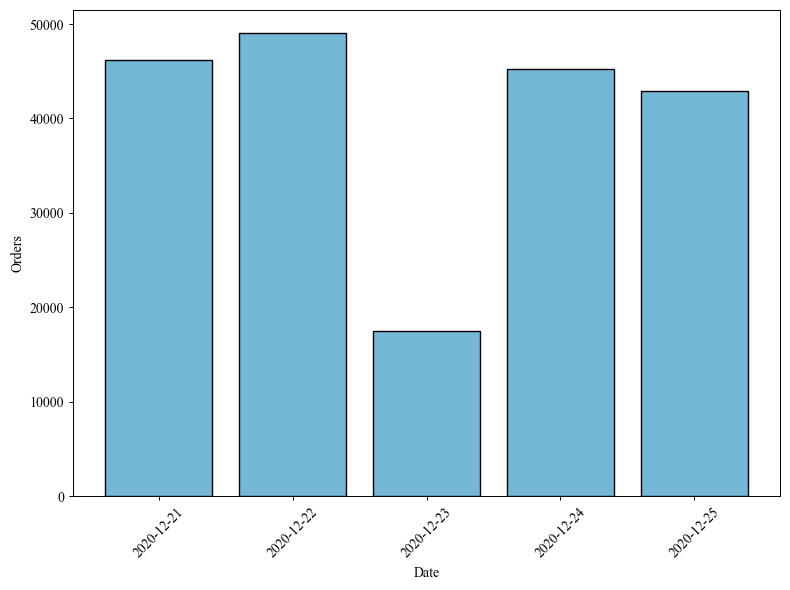

/var/folders/sg/4tbtggb55k590h6qc67thpgr0000gn/T/ipykernel_28709/2775849443.py:37: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-muted')  # Use a subdued style for better clarity


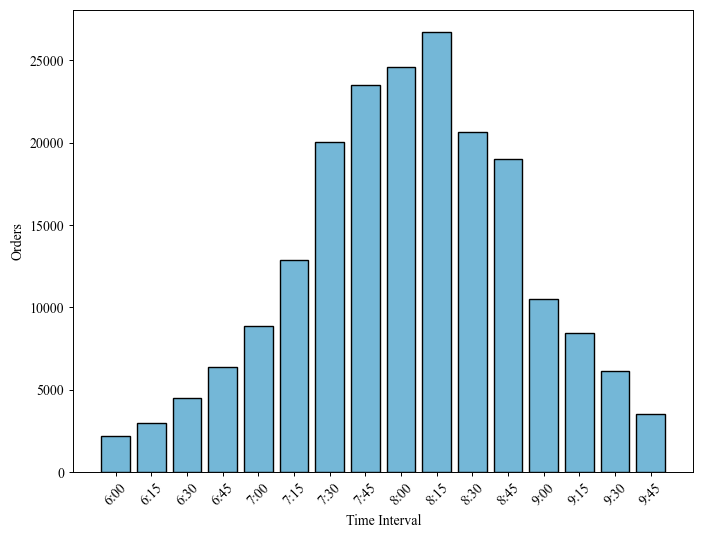

/var/folders/sg/4tbtggb55k590h6qc67thpgr0000gn/T/ipykernel_28709/2775849443.py:56: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-muted')  # Use a subdued style for better clarity


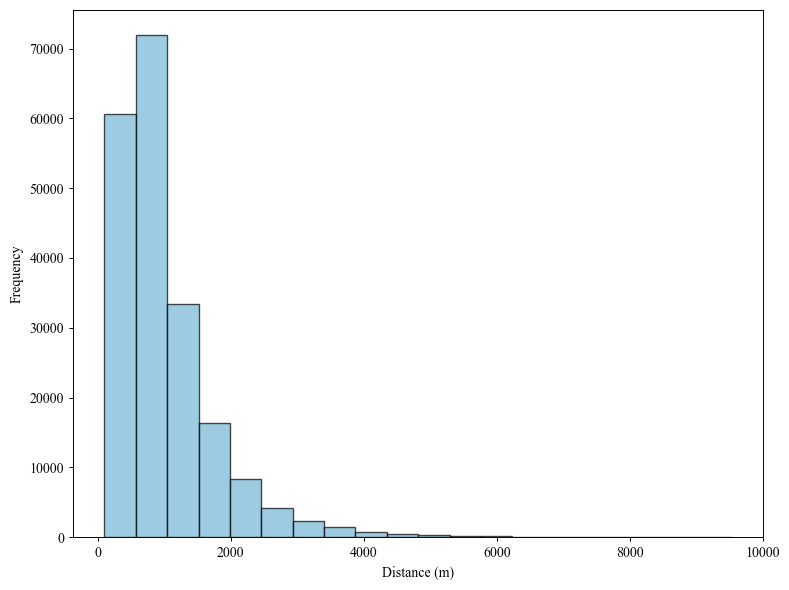

/var/folders/sg/4tbtggb55k590h6qc67thpgr0000gn/T/ipykernel_28709/2775849443.py:70: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-muted')  # Use a subdued style for better clarity


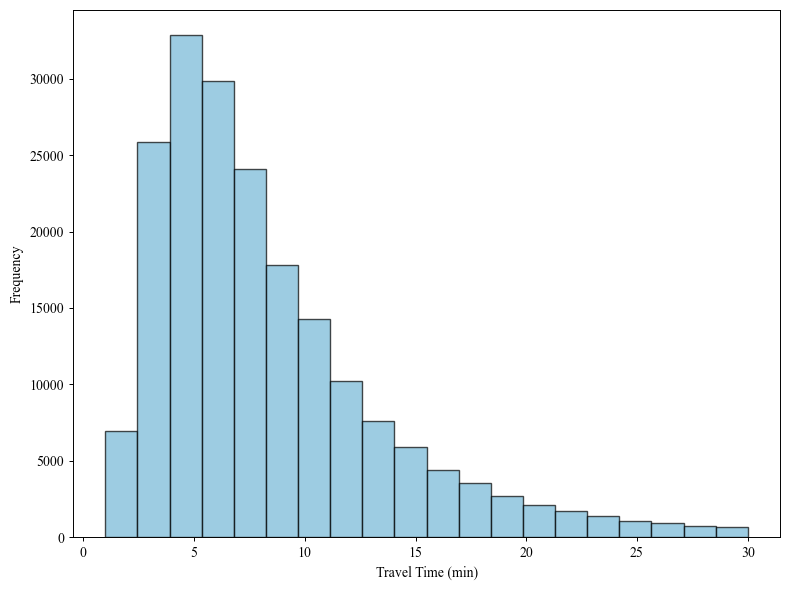

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# Set up the style to match SCI standards
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.linewidth'] = 0.7
plt.rcParams['xtick.major.width'] = 0.7
plt.rcParams['ytick.major.width'] = 0.7
plt.rcParams['xtick.major.size'] = 3
plt.rcParams['ytick.major.size'] = 3

df = move_data.copy()

# Convert date columns to datetime format
df['stime'] = pd.to_datetime(df['stime'])
df['etime'] = pd.to_datetime(df['etime'])

# Plot 1: Bar chart of daily order count with rotated x-axis labels
plt.figure(figsize=(8, 6))
plt.style.use('seaborn-muted')  # Use a subdued style for better clarity
df['date'] = df['stime'].dt.date
daily_order_count = df['date'].value_counts().sort_index()
plt.bar(daily_order_count.index,
        daily_order_count.values,
        color='#74B7D7',  #-----------------改颜色
        edgecolor='black')
plt.xlabel('Date')
plt.ylabel('Orders')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.savefig('./picture/Daily distribution.svg', format='svg')
plt.show()

# Plot 2: Bar chart of order count by time intervals (15-min intervals) with rotated x-axis labels
plt.figure(figsize=(8, 6))
plt.style.use('seaborn-muted')  # Use a subdued style for better clarity
df['hour'] = df['stime'].dt.hour
df['minute'] = df['stime'].dt.minute // 15 * 15  # Calculate 15-min intervals
df['time_interval'] = df.apply(lambda row: f"{row['hour']}:{row['minute']:02d}", axis=1)  # Format with leading zeros
time_interval_order_count = df[df['hour'].between(6, 9)]['time_interval'].value_counts().sort_index()

plt.bar(time_interval_order_count.index,
        time_interval_order_count.values,
        color='#74B7D7',  #-----------------改颜色
        edgecolor='black')
plt.xlabel('Time Interval')
plt.ylabel('Orders')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.savefig('./picture/Temporal distribution.svg', format='svg')
plt.show()


# Plot 3: Histogram of distance frequency
plt.figure(figsize=(8, 6))
plt.style.use('seaborn-muted')  # Use a subdued style for better clarity
plt.hist(df['distance'],
         bins=20,
         color='#74B7D7',  #-----------------改颜色
         alpha=0.7,
         edgecolor='black')
plt.xlabel('Distance (m)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.savefig('./picture/Travel distance distribution.svg', format='svg')
plt.show()

# Plot 4: Histogram of travel time frequency
plt.figure(figsize=(8, 6))
plt.style.use('seaborn-muted')  # Use a subdued style for better clarity
df['travel_time'] = (df['etime'] - df['stime']).dt.total_seconds() / 60  # Calculate travel time in minutes
plt.hist(df['travel_time'],
         bins=20,
         range=(1, 30),
         color='#74B7D7',  #-----------------改颜色
         alpha=0.7,
         edgecolor='black')
plt.xlabel('Travel Time (min)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.savefig('./picture/Travel time distribution.svg', format='svg')
plt.show()


## 活动模式（空间分析）
探索不同地区的骑行活动模式，找出城市内不同区域的骑行偏好和活跃度
### 共享单车OD订单数据点的空间分布

In [10]:
# 以500米×500米的栅格为最小分析单元，对OD进行栅格集计
# 获取栅格划分参数
bounds = (118.0199, 24.4221, 118.1981, 24.5677)
params = tbd.area_to_params(bounds,accuracy = 500)
#集计OD
od_gdf = tbd.odagg_grid(move_data, params, col=['slon', 'slat', 'elon', 'elat'])
od_gdf.head(5)

SLONCOL  SLATCOL  ELONCOL  ELATCOL  count      SHBLON     SHBLAT  \
17119       36       14       30       11      1  118.197788  24.485052   
5632        18       27       19       30      1  118.108844  24.543508   
12923       27        6       33       14      1  118.153316  24.449080   
5628        18       27       18       29      1  118.108844  24.543508   
5627        18       27       18       28      1  118.108844  24.543508   

           EHBLON     EHBLAT  \
17119  118.168140  24.471563   
5632   118.113785  24.556998   
12923  118.182964  24.485052   
5628   118.108844  24.552502   
5627   118.108844  24.548005   

                                                geometry  
17119  LINESTRING (118.19779 24.48505, 118.16814 24.4...  
5632   LINESTRING (118.10884 24.54351, 118.11379 24.5...  
12923  LINESTRING (118.15332 24.44908, 118.18296 24.4...  
5628   LINESTRING (118.10884 24.54351, 118.10884 24.5...  
5627   LINESTRING (118.10884 24.54351, 118.10884 24.5...

/var/folders/sg/4tbtggb55k590h6qc67thpgr0000gn/T/ipykernel_68130/4175849050.py:28: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  subway_lines = subway_xm.groupby('line')['Lng', 'Lat'].apply(lambda x: x.values.tolist()).to_dict()


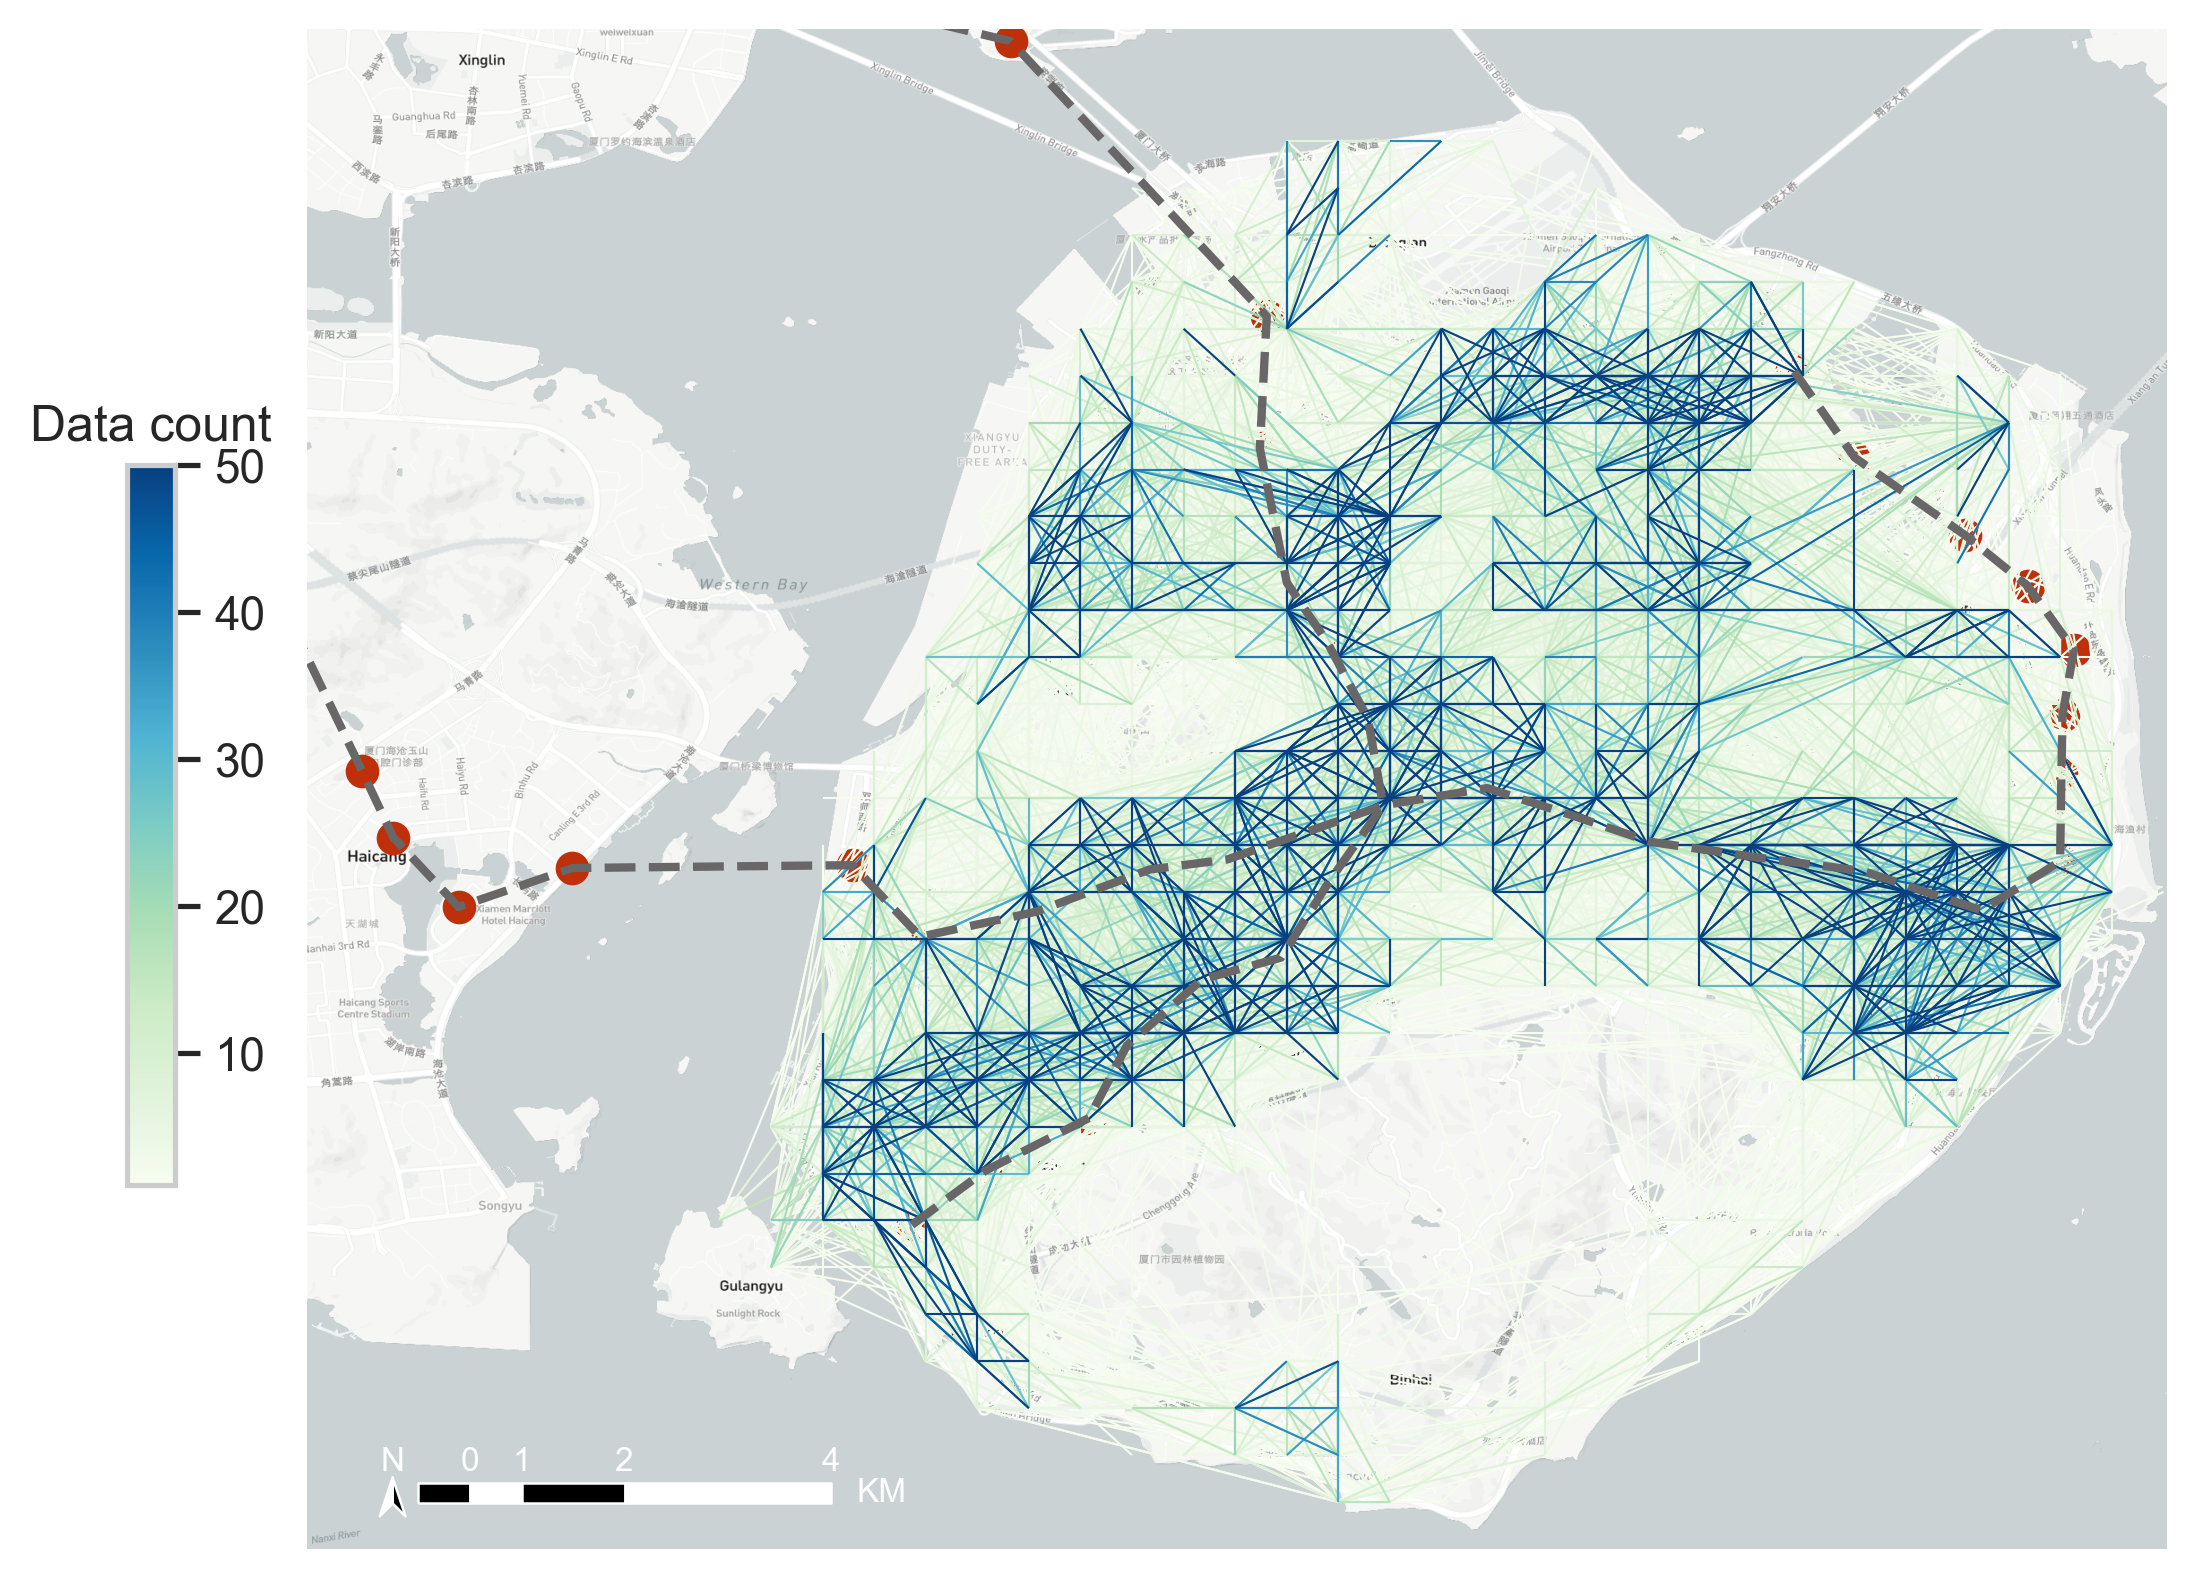

In [12]:
import seaborn as sns
import geopandas as gpd
from shapely.geometry import Polygon, Point
from shapely.geometry import LineString
import matplotlib.pyplot as plt

# 设置Seaborn的绘图风格和配色方案
sns.set(style="whitegrid", palette="colorblind")

# 创建图框
fig = plt.figure(1, (8, 8), dpi=300)
ax = plt.subplot(111)
plt.sca(ax)

# 添加地图底图
tbd.plot_map(plt, bounds, zoom=14, style=4)

# 绘制colorbar
cax = plt.axes([0.05, 0.33, 0.02, 0.3])
plt.title('Data count')
plt.sca(ax)

# 将地铁站点的经纬度数据转换为几何点
subway_geometry = gpd.points_from_xy(subway_xm['Lng'], subway_xm['Lat'])
gdf_subway = gpd.GeoDataFrame(subway_xm, geometry=subway_geometry)

# Group subway stations by line
subway_lines = subway_xm.groupby('line')['Lng', 'Lat'].apply(lambda x: x.values.tolist()).to_dict()

# Create LineString geometries for subway lines
line_geometries = []

for line, line_coords in subway_lines.items():
    line_geometry = LineString(line_coords)
    line_geometries.append({'geometry': line_geometry, 'line': line})

# Convert LineString geometries to GeoDataFrame
# gdf_subway_lines = gpd.GeoDataFrame(line_geometries, geometry='geometry', crs=gdf_subway_stations.crs)


# 创建地铁线路和站点的GeoDataFrame
gdf_subway_stations = gpd.GeoDataFrame(subway_xm, geometry=subway_geometry)
gdf_subway_lines = gpd.GeoDataFrame(line_geometries)

# 绘制OD轨迹
od_gdf.plot(ax=ax,
            column='count',
            cmap='GnBu',
            linewidth=0.5,
            vmax=50,
            cax=cax,
            legend=True)

# 绘制地铁线路，使用箭头线样式
gdf_subway_lines.plot(ax=ax, linestyle='dashed', color='#686666', linewidth=2, marker='o', markersize=10)

# 绘制地铁站点
gdf_subway_stations.plot(ax=ax, marker='o', color='#BE2F0A', markersize=50)

# 添加比例尺和指北针
tbd.plotscale(ax, bounds=bounds, textsize=8, compasssize=0.5, textcolor='white', accuracy=500, rect=[0.06, 0.03], zorder=10)

plt.axis('off')
plt.xlim(bounds[0], bounds[2])
plt.ylim(bounds[1], bounds[3])

plt.show()
fig.savefig('./picture/OD_map.svg', format='svg')

###  不同时间段共享单车出行的空间分布，从上到下分别是出发地、目的地

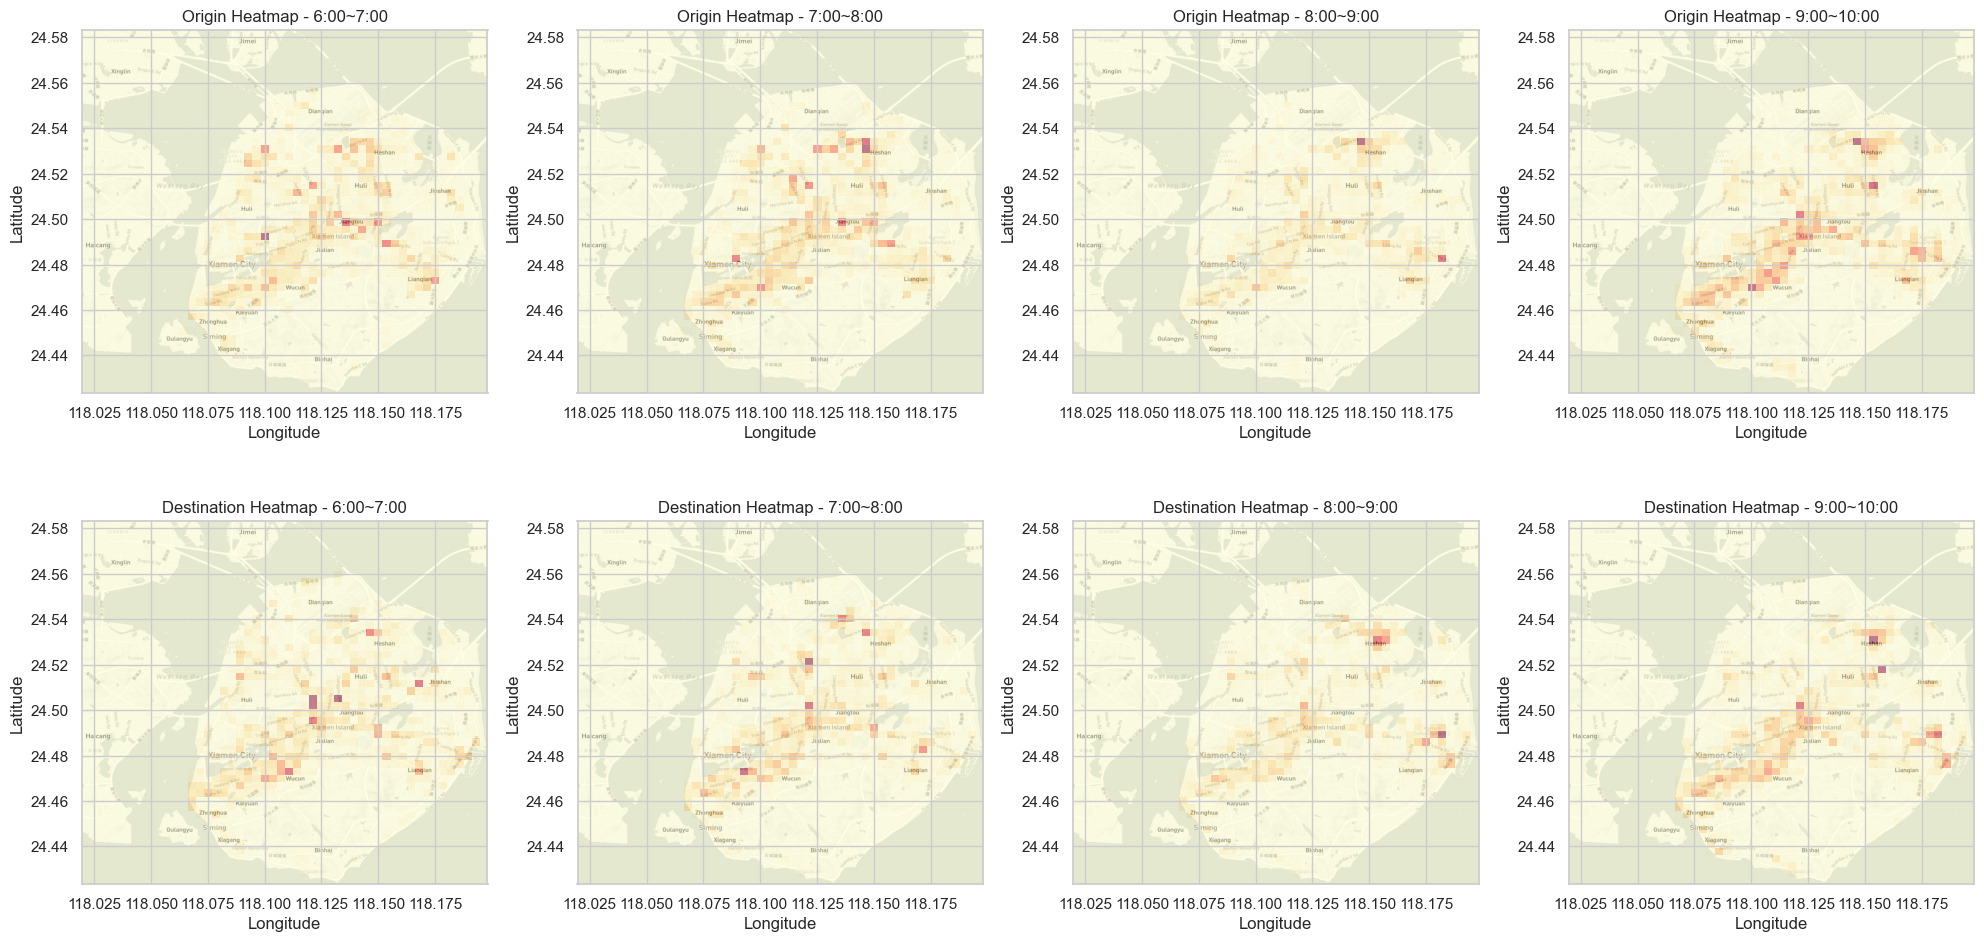

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import transbigdata
from transbigdata import plot_map

# Convert datetime columns to datetime objects (replace with your data loading code)
move_data['stime'] = pd.to_datetime(move_data['stime'])
move_data['etime'] = pd.to_datetime(move_data['etime'])

# Define the time ranges
time_ranges = {
    '6:00~7:00': (6, 7),
    '7:00~8:00': (7, 8),
    '8:00~9:00': (8, 9),
    '9:00~10:00': (9, 10)
}

# Filter data within the specified time range
start_time = pd.Timestamp('2020-12-21 06:00:00')
end_time = pd.Timestamp('2020-12-25 10:00:00')
filtered_data = move_data[(move_data['stime'] >= start_time) & (move_data['etime'] <= end_time)]

# Set up subplots
fig, axs = plt.subplots(2, 4, figsize=(20, 10))
fig.subplots_adjust(hspace=0.4)

# Define map bounds and zoom level
bounds = [118.0196, 24.4234, 118.1981, 24.5833]
zoom = 'auto'  # Use 'auto' for automatic zoom level

# Iterate through time ranges and create heatmaps
for i, (time_range, (start_hour, end_hour)) in enumerate(time_ranges.items()):
    row = i // 4
    col = i % 4
    ax_origin = axs[row, col]  # Get the corresponding subplot for origin heatmap
    ax_dest = axs[row + 1, col]  # Get the corresponding subplot for destination heatmap
    
    # Filter data within the current time range
    time_filtered_data = filtered_data[
        (filtered_data['stime'].dt.hour >= start_hour) & (filtered_data['stime'].dt.hour < end_hour)
    ]
    
    # Calculate map bounds based on filtered data
    min_lon = bounds[0]
    max_lon = bounds[2]
    min_lat = bounds[1]
    max_lat = bounds[3]
    
    # Generate origin heatmap data
    origin_heatmap, xedges, yedges = np.histogram2d(
        time_filtered_data['slon'], time_filtered_data['slat'], bins=50,
        range=[[min_lon, max_lon], [min_lat, max_lat]]
    )
    
    # Generate destination heatmap data
    dest_heatmap, xedges, yedges = np.histogram2d(
        time_filtered_data['elon'], time_filtered_data['elat'], bins=50,
        range=[[min_lon, max_lon], [min_lat, max_lat]]
    )
    
    # Plot origin heatmap with map background
    plot_map(ax_origin, bounds, zoom=zoom, style=4)  # Add map background
    ax_origin.imshow(origin_heatmap.T, cmap='YlOrRd', extent=[min_lon, max_lon, min_lat, max_lat], origin='lower', alpha=0.5)
    
    # Plot destination heatmap with map background
    plot_map(ax_dest, bounds, zoom=zoom, style=4)  # Add map background
    ax_dest.imshow(dest_heatmap.T, cmap='YlOrRd', extent=[min_lon, max_lon, min_lat, max_lat], origin='lower', alpha=0.5)

    # Set titles and labels
    ax_origin.set_title(f'Origin Heatmap - {time_range}')
    ax_dest.set_title(f'Destination Heatmap - {time_range}')
    ax_origin.set_xlabel('Longitude')
    ax_origin.set_ylabel('Latitude')
    ax_dest.set_xlabel('Longitude')
    ax_dest.set_ylabel('Latitude')

# Show the plots
plt.tight_layout()

plt.show()


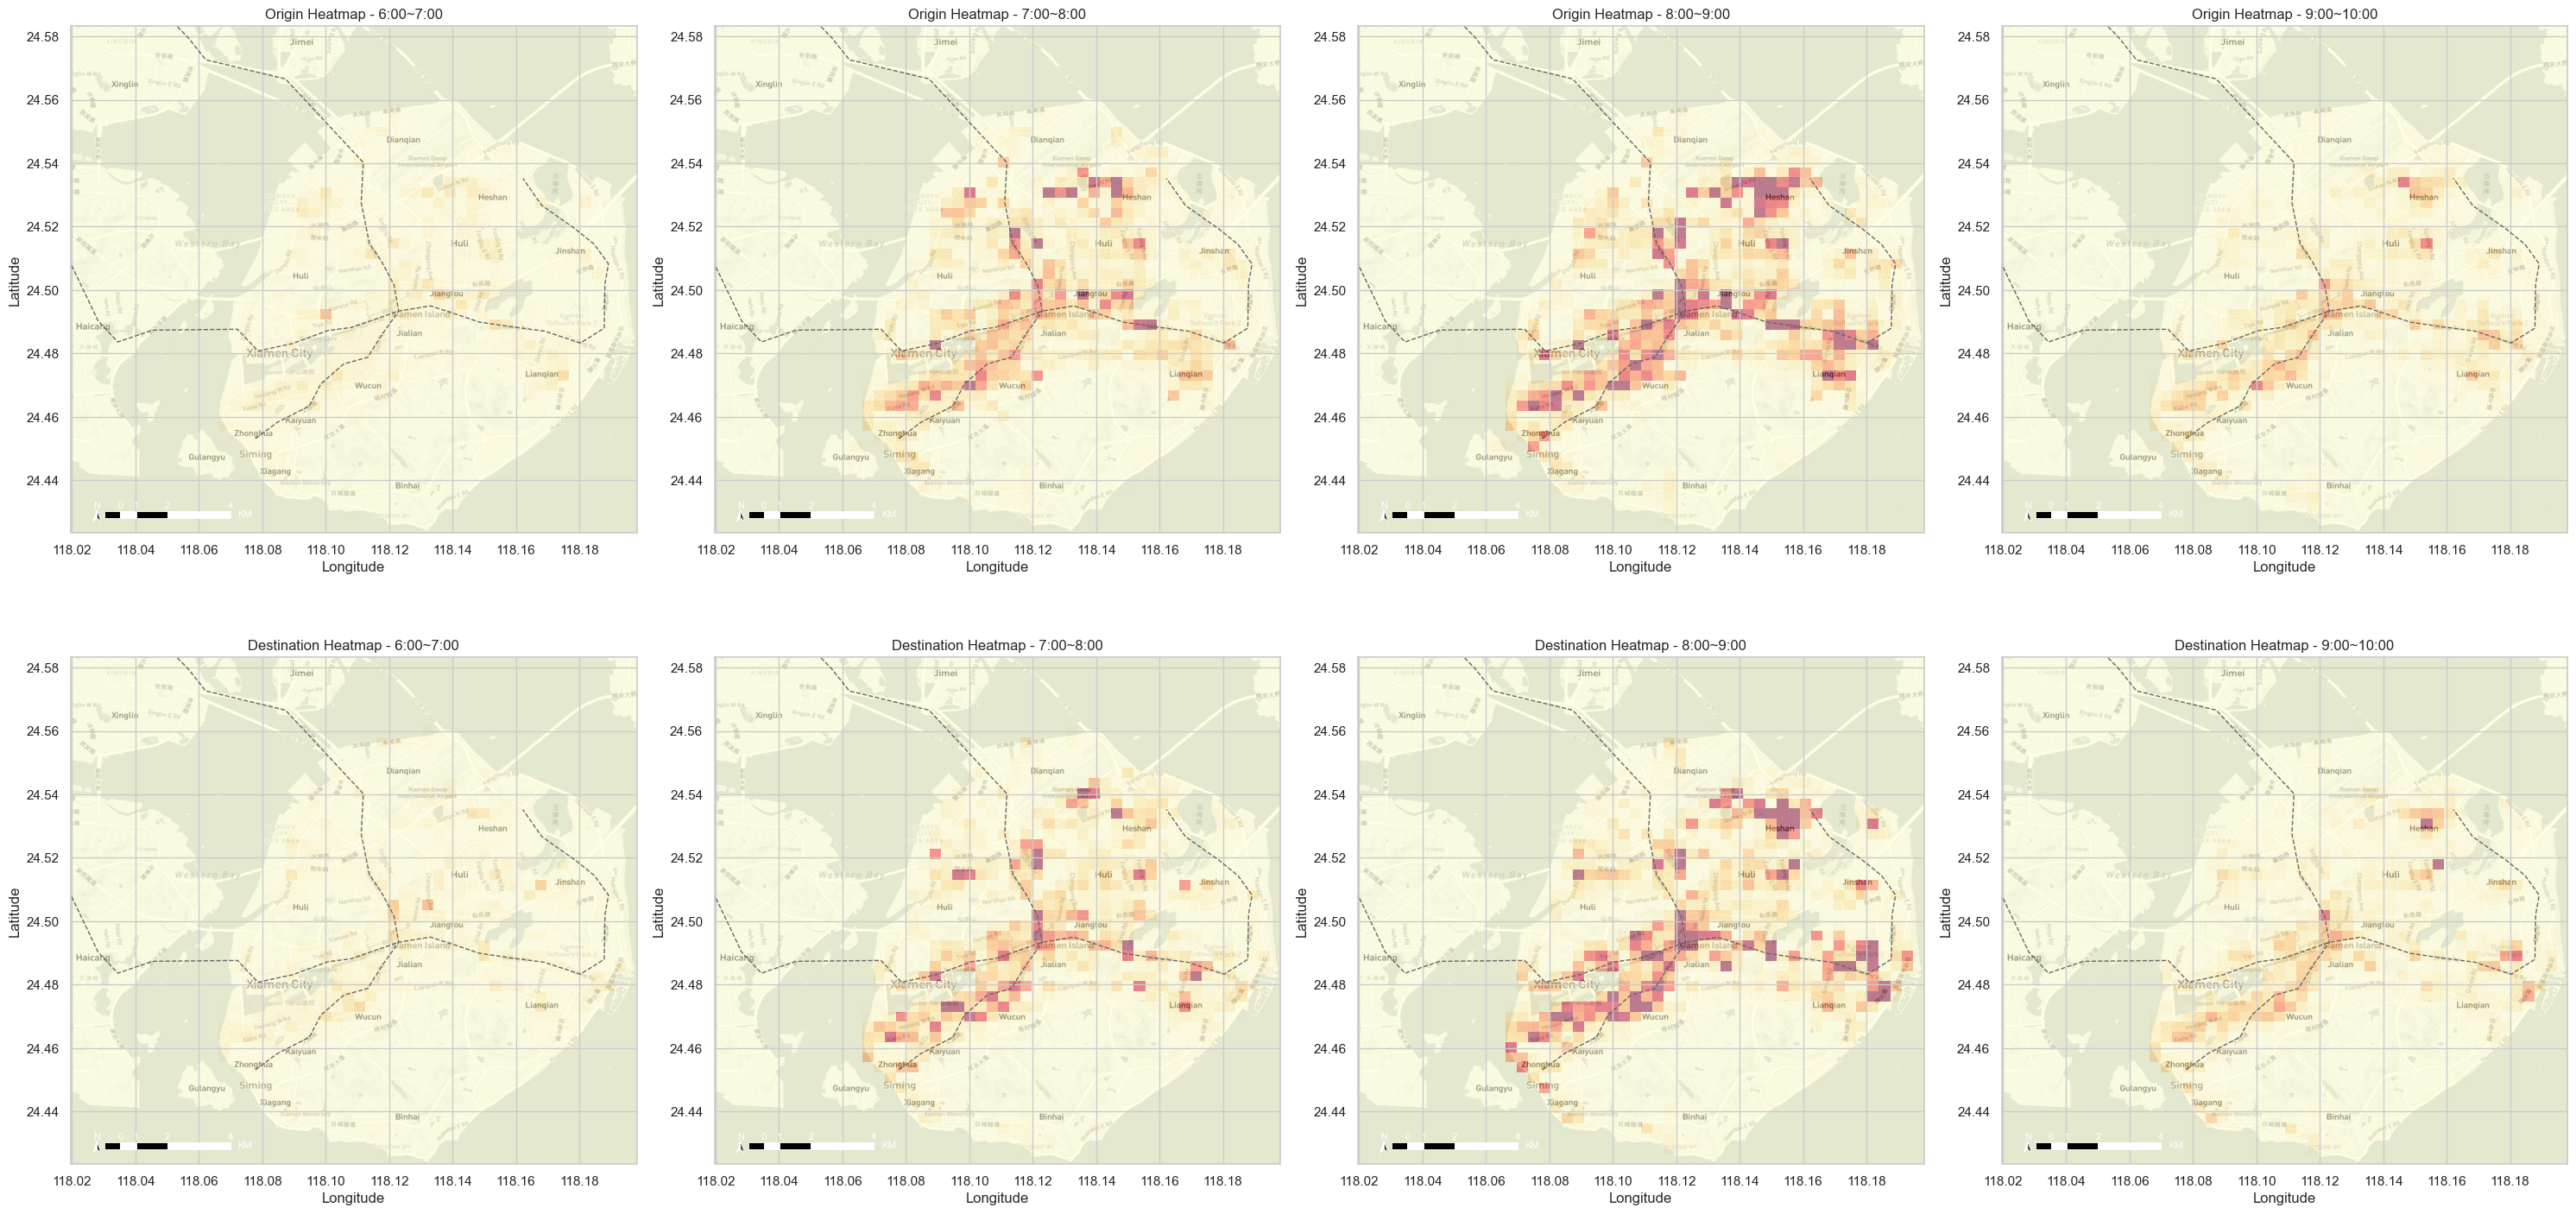

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import transbigdata
from transbigdata import plot_map
import seaborn as sns

# Set Seaborn style
sns.set(style="whitegrid", palette="colorblind", context="notebook")

# Convert datetime columns to datetime objects (replace with your data loading code)
move_data['stime'] = pd.to_datetime(move_data['stime'])
move_data['etime'] = pd.to_datetime(move_data['etime'])

# Define the time ranges
time_ranges = {
    '6:00~7:00': (6, 7),
    '7:00~8:00': (7, 8),
    '8:00~9:00': (8, 9),
    '9:00~10:00': (9, 10)
}

# Filter data within the specified time range
start_time = pd.Timestamp('2020-12-21 06:00:00')
end_time = pd.Timestamp('2020-12-25 10:00:00')
time_filtered_data = move_data[(move_data['stime'] >= start_time) & (move_data['etime'] <= end_time)]

# Normalize the color scale using the maximum value from all heatmaps
max_value = max(np.max(origin_heatmap), np.max(dest_heatmap))
norm = Normalize(vmin=0, vmax=max_value)

# Create a figure with a 2x4 grid layout
fig, axs = plt.subplots(2, 4, figsize=(30, 15))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

# Iterate through time ranges and create heatmaps
for i, (time_range, (start_hour, end_hour)) in enumerate(time_ranges.items()):
    current_time_filtered_data = time_filtered_data[
        (time_filtered_data['stime'].dt.hour >= start_hour) &
        (time_filtered_data['etime'].dt.hour < end_hour)
    ]

    # Generate origin and destination heatmap data
    origin_heatmap, xedges, yedges = np.histogram2d(
        current_time_filtered_data['slon'], current_time_filtered_data['slat'], bins=50,
        range=[[min_lon, max_lon], [min_lat, max_lat]]
    )
    
    dest_heatmap, xedges, yedges = np.histogram2d(
        current_time_filtered_data['elon'], current_time_filtered_data['elat'], bins=50,
        range=[[min_lon, max_lon], [min_lat, max_lat]]
    )
    
    # Plot subway lines
    gdf_subway_lines.plot(ax=axs[0, i], linestyle='dashed', color='#686666', linewidth=1, marker='o', markersize=10)
    gdf_subway_lines.plot(ax=axs[1, i], linestyle='dashed', color='#686666', linewidth=1, marker='o', markersize=10)

    # Plot origin heatmap with map background
    plot_map(axs[0, i], bounds, zoom=zoom, style=4)
    im1 = axs[0, i].imshow(origin_heatmap.T, cmap='YlOrRd', extent=[min_lon, max_lon, min_lat, max_lat], origin='lower', alpha=0.5, norm=norm)
    axs[0, i].set_title(f'Origin Heatmap - {time_range}')
    axs[0, i].set_xlabel('Longitude')
    axs[0, i].set_ylabel('Latitude')
    axs[0, i].set_xlim(min_lon, max_lon)  # Set x-axis limits
    axs[0, i].set_ylim(min_lat, max_lat)  # Set y-axis limits

    # Plot destination heatmap with map background
    plot_map(axs[1, i], bounds, zoom=zoom, style=4)
    im2 = axs[1, i].imshow(dest_heatmap.T, cmap='YlOrRd', extent=[min_lon, max_lon, min_lat, max_lat], origin='lower', alpha=0.5, norm=norm)
    axs[1, i].set_title(f'Destination Heatmap - {time_range}')
    axs[1, i].set_xlabel('Longitude')
    axs[1, i].set_ylabel('Latitude')
    axs[1, i].set_xlim(min_lon, max_lon)  # Set x-axis limits
    axs[1, i].set_ylim(min_lat, max_lat)  # Set y-axis limits
    
    # Add scale and compass
    tbd.plotscale(ax=axs[0, i], bounds=bounds, textsize=8, compasssize=0.5, textcolor='white', accuracy=500, rect=[0.06, 0.03], zorder=10)
    tbd.plotscale(ax=axs[1, i], bounds=bounds, textsize=8, compasssize=0.5, textcolor='white', accuracy=500, rect=[0.06, 0.03], zorder=10)

# Show the plots and save as SVG
plt.tight_layout()
fig.savefig('./picture/combined_heatmaps.svg', format='svg')
plt.show()


## Human Daily activity recognition
### Distribution of Parking Fence by Main Function(POI)

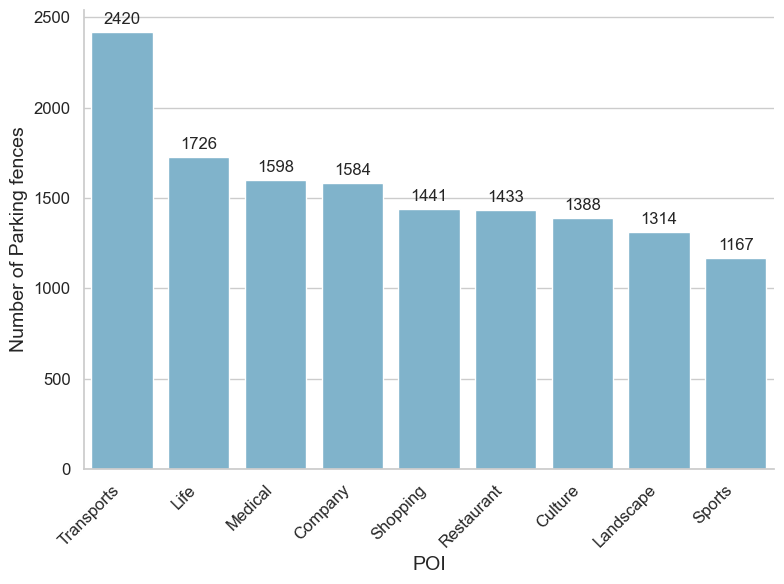

In [13]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 统计主要功能数量
main_function_counts = df_fence['Main_Function'].value_counts()

# 设置Seaborn样式
sns.set(style="whitegrid")

# 创建柱状图
plt.figure(figsize=(8, 6))
bar_plot = sns.barplot(x=main_function_counts.index,
                       y=main_function_counts.values,
                       color='#74B7D7')

# 设置标题和标签
plt.xlabel("POI", fontsize=14)
plt.ylabel("Number of Parking fences", fontsize=14)
plt.xticks(rotation=45, ha="right", fontsize=12)
plt.yticks(fontsize=12)

# 去除上方和右侧的边框
sns.despine()

# 在每个柱上显示具体数量
for p in bar_plot.patches:
    bar_plot.annotate(
        format(p.get_height(), '.0f'),
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center',
        va='center',
        xytext=(0, 9),  # 调整标签的位置
        textcoords='offset points',
        fontsize=12)

# 显示图表
plt.tight_layout()
plt.savefig('./picture/Distribution_POIn.svg', format='svg')
plt.show()

In [14]:
import pandas as pd
from rtree import index

def build_poi_index(POI):
    p = index.Property()
    poi_idx = index.Index(properties=p)
    for idx, poi in POI.iterrows():
        poi_idx.insert(idx, (poi['Lng'], poi['Lat'], poi['Lng'], poi['Lat']))
    return poi_idx

def assign_main_function(poi_idx, lon, lat):
    fence_center = (lon, lat)
    nearest_poi_indices = list(poi_idx.nearest(fence_center, 1))
    if nearest_poi_indices:
        nearest_poi_idx = nearest_poi_indices[0]
        nearest_poi_type = POI.loc[nearest_poi_idx, 'type']
        return nearest_poi_type
    else:
        return None

# 构建R-Tree索引
poi_idx = build_poi_index(POI)

move_data['s_POI'] = move_data.apply(lambda row: assign_main_function(poi_idx, row['slon'], row['slat']), axis=1)
move_data['e_POI'] = move_data.apply(lambda row: assign_main_function(poi_idx, row['elon'], row['elat']), axis=1)


### A chord diagram of the mobility of bike-sharing between different POI types

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
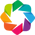

/var/folders/sg/4tbtggb55k590h6qc67thpgr0000gn/T/ipykernel_68130/501412187.py:14: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  node = pd.DataFrame(link_data['s_POI'].append(link_data['e_POI']).unique(),


In [15]:
import pandas as pd
import numpy as np
import holoviews as hv
from holoviews import opts, dim

hv.extension('bokeh')

# 计算每个连接线的长度（比例）
link_data = move_data.groupby(['s_POI',
                               'e_POI']).size().reset_index(name='count')
link_data['value'] = link_data['count'] / link_data['count'].sum()

# 创建节点和连接线的数据 弦的方向就是 s_POI -> e_POI
node = pd.DataFrame(link_data['s_POI'].append(link_data['e_POI']).unique(),
                    columns=['n'])
nodes = hv.Dataset(
    node,
    'n',
)

chord = hv.Chord((link_data, nodes), ['s_POI', 'e_POI'], ['count'])

# 可选择节点数
busiest = node['n'].to_list()
Chord = chord.select(AirportID=busiest, selection_mode='nodes')

Chord.opts(
    opts.Chord(cmap='Tab20',
               edge_color=dim('s_POI').str(),
               height=500,
               width=500,
               labels='n',
               node_color='n',
               edge_visible=True))

hv.save(Chord, r'./picture/Chord.html')

In [16]:
total_value_per_s_POI = link_data.groupby('s_POI')['value'].sum()
total_value_per_s_POI

s_POI
Company       0.115643
Culture       0.079012
Landscape     0.078858
Life          0.128925
Medical       0.101091
Restaurant    0.114289
Shopping      0.104745
Sports        0.082666
Transports    0.194770
Name: value, dtype: float64

### Origin POI and Destination POI

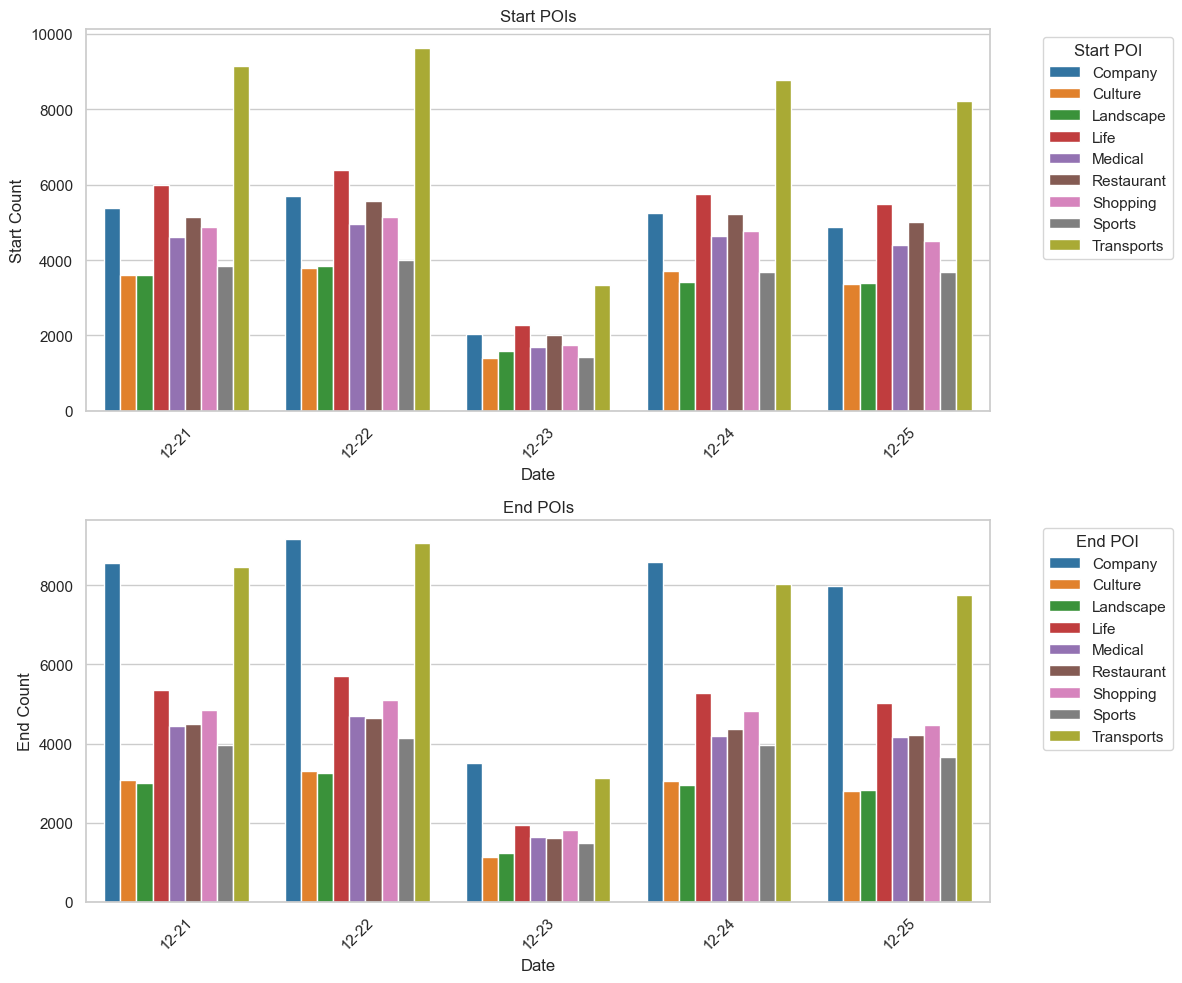

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 将时间列转换为日期格式
move_data['stime'] = pd.to_datetime(move_data['stime'])
move_data['etime'] = pd.to_datetime(move_data['etime'])

# 提取日期信息（月份和日）
move_data['date'] = move_data['stime'].dt.strftime('%m-%d')

# 按日期和起始点 POI 进行分组，并计算每组的数量
start_poi_counts = move_data.groupby(['date', 's_POI']).size().reset_index(name='start_count')

# 按日期和目的地 POI 进行分组，并计算每组的数量
end_poi_counts = move_data.groupby(['date', 'e_POI']).size().reset_index(name='end_count')

# 设置 Seaborn 风格
sns.set(style="whitegrid")
sns.set_palette("tab10")  # 使用 SCI 配色方案

# 创建一个包含两个子图的画布
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 10))

# 起始点 POI 子图
sns.barplot(ax=axes[0], x='date', y='start_count', hue='s_POI', data=start_poi_counts)
axes[0].set_title('Start POIs')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Start Count')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)
axes[0].legend(title='Start POI', bbox_to_anchor=(1.05, 1), loc='upper left')

# 目的地 POI 子图
sns.barplot(ax=axes[1], x='date', y='end_count', hue='e_POI', data=end_poi_counts)
axes[1].set_title('End POIs')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('End Count')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45)
axes[1].legend(title='End POI', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.savefig('./picture/POI counts.svg', format='svg')
plt.show()


# Identification of BS Hotspots and Coldspots
* 使用经纬度距离匹配的方法来进行尝试，具体的思路为计算订单最近的停车点，进而计算具体的潮汐情况。
* 潮汐指数Tide Index：TI = (还车数量-取车数量)/停车能力，基于停车点位的动态流动和停车能力之间的关系量化潮汐指数
        * 潮汐指数 > 1：表示停车点位的流入车辆相对流出车辆较多，停车需求可能较高，可能是热点。
        * 0 < 潮汐指数 < 1：表示停车点位的流出车辆相对流入车辆较多，停车需求可能较低，可能是冷点。
        * 潮汐指数越大，停车点位的流入车辆相对流出车辆越多，热度越高。
* 由于12-23是中雨天气，共享单车出行受到严重影响，因此在热点的识别与分类中，将2020-12-23全天的数据删除

In [20]:
# 删除2020-12-23这一天的数据
df_order = df_order[df_order['DAY'] != 23]

In [21]:
import numpy as np
import pandas as pd
from sklearn.neighbors import NearestNeighbors
import hnswlib

# 数据预处理
# 拆分 FENCE_CENTER 列
df_fence[['FENCE_CENTER_LAT', 'FENCE_CENTER_LONG']] = pd.DataFrame(df_fence['FENCE_CENTER'].tolist(), index=df_fence.index)

# Nearest Neighbors 模型
knn = NearestNeighbors(metric="haversine", n_jobs=-1, algorithm='ball_tree')
knn.fit(df_fence[['FENCE_CENTER_LAT', 'FENCE_CENTER_LONG']].values)

# 计算最近的停车点
dist, index = knn.kneighbors(df_order[['LATITUDE', 'LONGITUDE']], n_neighbors=1)
df_order['FENCE_ID'] = df_fence.iloc[index.flatten()]['FENCE_ID'].values

# 初始化 HNSWLIB Index
p = hnswlib.Index(space='l2', dim=2)
p.init_index(max_elements=len(df_fence), ef_construction=200, M=48)  # 调整参数
p.set_ef(1024)
p.set_num_threads(14)

# 将停车点坐标添加到 HNSWLIB Index
p.add_items(df_fence[['FENCE_CENTER_LAT', 'FENCE_CENTER_LONG']].values)

df_fence["Count"] = df_fence["FENCE_ID"].map(df_order["FENCE_ID"].value_counts()).fillna(0)

/opt/anaconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but NearestNeighbors was fitted without feature names
  warnings.warn(


In [22]:
import pandas as pd

# 固定时间段
time_interval = '60T'

# 统计流入数量和流出数量
bike_inflow = df_order[df_order['LOCK_STATUS'] == 1].groupby(['FENCE_ID', pd.Grouper(key='UPDATE_TIME', freq=time_interval)])['LOCK_STATUS'].count()
bike_outflow = df_order[df_order['LOCK_STATUS'] == 0].groupby(['FENCE_ID', pd.Grouper(key='UPDATE_TIME', freq=time_interval)])['LOCK_STATUS'].count()

# 计算潮汐指数
tide_index = (bike_inflow - bike_outflow) / (df_fence.set_index('FENCE_ID')['PARKING_CAPACITY'])

# 去除潮汐指数中的缺失值
tide_index.dropna(inplace=True)

agg_tide_index = tide_index.groupby('FENCE_ID').mean()

# 根据潮汐指数识别冷热点
hotspots = agg_tide_index[agg_tide_index > 1]
coldspots = agg_tide_index[(0 < agg_tide_index) & (agg_tide_index < 1)]

# 创建Hotspots和Coldspots数据集
df_hotspots = pd.DataFrame({'FENCE_ID': hotspots.index.get_level_values(0), 'agg_tide_index': hotspots.values})
df_hotspots['FENCE_LOC'] = df_hotspots['FENCE_ID'].map(df_fence.set_index('FENCE_ID')['FENCE_LOC'])
df_hotspots['PARKING_CAPACITY'] = df_hotspots['FENCE_ID'].map(df_fence.set_index('FENCE_ID')['PARKING_CAPACITY'])
df_hotspots['Main_Function'] = df_hotspots['FENCE_ID'].map(df_fence.set_index('FENCE_ID')['Main_Function'])
df_hotspots['Count'] = df_hotspots['FENCE_ID'].map(df_fence.set_index('FENCE_ID')['Count'])

df_coldspots = pd.DataFrame({'FENCE_ID': coldspots.index.get_level_values(0), 'agg_tide_index': coldspots.values})
df_coldspots['FENCE_LOC'] = df_coldspots['FENCE_ID'].map(df_fence.set_index('FENCE_ID')['FENCE_LOC'])
df_coldspots['PARKING_CAPACITY'] = df_coldspots['FENCE_ID'].map(df_fence.set_index('FENCE_ID')['PARKING_CAPACITY'])
df_coldspots['Main_Function'] = df_coldspots['FENCE_ID'].map(df_fence.set_index('FENCE_ID')['Main_Function'])
df_coldspots['Count'] = df_coldspots['FENCE_ID'].map(df_fence.set_index('FENCE_ID')['Count'])

In [23]:
def categorize_main_function(main_function):
    if main_function in ['Life', 'Meditation']:
        return 'residential'
    elif main_function in ['Sports', 'Culture', 'Landscape']:
        return 'recreation'
    elif main_function in [
            'Transports', 'Company', 'Shopping', 'Restaurant'
    ]:
        return 'commercial'
    else:
        return 'Other'


df_hotspots['POI_category'] = df_hotspots['Main_Function'].apply(
    categorize_main_function)
df_coldspots['POI_category'] = df_coldspots['Main_Function'].apply(
    categorize_main_function)

In [24]:
df_hotspots.sort_values(by='agg_tide_index', ascending=False).head(10)

FENCE_ID  agg_tide_index  \
56            望海路0_R_2       12.406250   
76  观日路(望海路至会展路段 )_R_1        7.529412   
80            象屿路0_R_1        6.736111   
55            望海路0_R_1        5.614583   
8           云顶北路0_R_45        4.323077   
0            云顶中路0_L_4        4.316667   
84       金边路0_R_A04004        3.163636   
54            望海路0_L_1        3.160000   
63           湖里大道0_L_9        2.976190   
70          环岛干道0_R_33        2.875000   

                                            FENCE_LOC  PARKING_CAPACITY  \
56  [[118.179600502, 24.4916542622], [118.17958991...               4.0   
76  [[118.1811945889, 24.4881023165], [118.1811646...               6.0   
80  [[118.088508795, 24.5137777608], [118.08849974...               4.0   
55  [[118.181675856, 24.4898229298], [118.18159669...               6.0   
8   [[118.146595443, 24.5377544107], [118.14657921...               5.0   
0   [[118.148596098, 24.4906753286], [118.14857984...               4.0   
84  [[118.1630324, 24.495621], [118.163026, 24.495...               5.0   
54  [[118.179554684, 24.4914374455], [118.17954243...               5.0   
63  [[118.098107086, 24.5142926753], [118.09800838...               7.0   
70  [[118.18230799, 24.4849448904], [118.182292864...               4.0   

   Main_Function   Count POI_category  
56       Company   507.0   commercial  
76       Company  2251.0   commercial  
80    Transports   707.0   commercial  
55       Company  1233.0   commercial  
8        Company   831.0   commercial  
0     Transports   381.0   commercial  
84        Sports   361.0   recreation  
54       Company   464.0   commercial  
63       Culture   379.0   recreation  
70       Company   431.0   commercial

In [25]:
df_coldspots.sort_values(by='agg_tide_index', ascending=True).head(10)

FENCE_ID  agg_tide_index  \
345             华光西路0_L_1    5.551115e-18   
308              创新三路_R_7    5.551115e-18   
1708         金尚路_R_B30020    5.551115e-18   
96          云顶北路_L_B27024    7.930164e-18   
1274  湖滨西路(鹭江道至厦禾路) _L_10    1.110223e-17   
435          厦禾路_R_A10013    1.189525e-17   
429   厦禾路_R_2(后埭西路至站西二路 )    1.233581e-17   
1985            鹭江道0_L_22    1.387779e-17   
451               台南路_L_5    2.775558e-17   
869   故宫路(禾祥西路至厦禾路段) _R_9    3.172066e-17   

                                              FENCE_LOC  PARKING_CAPACITY  \
345   [[118.105616969, 24.5174920973], [118.10559978...               3.0   
308   [[118.1235696062, 24.5197106829], [118.1235030...               6.0   
1708  [[118.141867, 24.494873], [118.141851, 24.4948...               5.0   
96    [[118.15162, 24.52355], [118.151608, 24.523601...               5.0   
1274  [[118.0742768316, 24.463283382], [118.07424700...              10.0   
435   [[118.089698, 24.466106], [118.089622, 24.4660...               6.0   
429   [[118.1032791294, 24.4695997291], [118.1032276...               5.0   
1985  [[118.068761519, 24.4648736184], [118.06874593...               5.0   
451   [[118.1918406459, 24.4862349166], [118.1918860...               5.0   
869   [[118.0778332836, 24.4662989664], [118.0777725...               5.0   

     Main_Function  Count POI_category  
345           Life   58.0  residential  
308        Company   99.0   commercial  
1708    Transports   53.0   commercial  
96         Culture   48.0   recreation  
1274       Company   73.0   commercial  
435           Life   57.0  residential  
429     Transports   62.0   commercial  
1985     Landscape   32.0   recreation  
451        Company   80.0   commercial  
869     Meditation   41.0  residential

# Classification of BS Hotspots and Coldspots

* High_demand: 高需求区域，这些点位潮汐指数较高，停车能力较低，且周边环境有吸引人的POI，表示需求大且供应不足。
* Balanced: 平衡区域，潮汐指数和停车能力相对平衡，周边环境可能有一些吸引人的POI，表示需求和供应相对匹配。
* Low_demand: 低需求区域，这些点位停车能力很大，但潮汐指数较小，可能周边环境没有吸引人的POI，表示供应充足但需求较小。

In [26]:
from sklearn.mixture import GaussianMixture
import pandas as pd
from sklearn.preprocessing import StandardScaler

df_combines = pd.concat([df_coldspots, df_hotspots], ignore_index=True)

df_combines_selected = df_combines[
    ['agg_tide_index', 'PARKING_CAPACITY', 'Count'] +
    [col for col in df_hotspots.columns if col.startswith('Main_Function_')]]

# 标准化特征
scaler = StandardScaler()
df_combines_scaled = scaler.fit_transform(df_combines_selected)

# 使用GaussianMixture聚类
num_clusters_hotspots = 3  # 根据需求设定聚类簇数
gmm = GaussianMixture(n_components=num_clusters_hotspots, random_state=42)
cluster_labels = gmm.fit_predict(df_combines_scaled)

# 将聚类标签添加到数据框中
df_combines['cluster_label'] = cluster_labels

# 根据聚类结果分别赋予类别名称
cluster_mapping = {
    0: 'Low_demand',
    1: 'High_demand',
    2: 'Balanced'
}
df_combines['Category'] = df_combines['cluster_label'].map(cluster_mapping)


In [27]:
df_combines['Category'].value_counts()

Balanced       1552
Low_demand      335
High_demand     270
Name: Category, dtype: int64

/var/folders/sg/4tbtggb55k590h6qc67thpgr0000gn/T/ipykernel_28709/172872673.py:20: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')


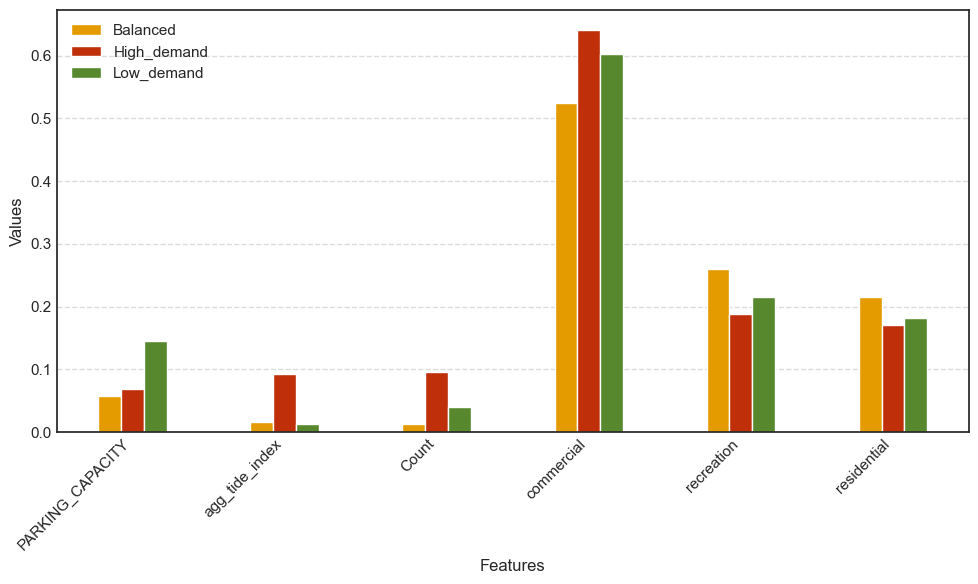

In [32]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn.preprocessing import MinMaxScaler

# 对agg_tide_index和PARKING_CAPACITY进行MinMax标准化
scaler = MinMaxScaler()
df_combines[['agg_tide_index', 'PARKING_CAPACITY', 'Count']] = scaler.fit_transform(df_combines[['agg_tide_index', 'PARKING_CAPACITY','Count']])

# 按Category分组并计算POI_category的占比
grouped_data = df_combines.groupby('Category').agg({
    'agg_tide_index': 'mean',
    'PARKING_CAPACITY': 'mean',
    'Count': 'mean',
    'POI_category': lambda x: dict(x.value_counts(normalize=True))
}).reset_index()

# 使用SCI插图风格
plt.style.use('seaborn-white')

# 设置颜色和标签
colors = {'High_demand': '#BE2F0A', 'Balanced': '#E39B00', 'Low_demand': '#57882D'}

# 绘制条形图
fig, ax = plt.subplots(figsize=(10, 6))

# 横坐标标签
categories = ['PARKING_CAPACITY', 'agg_tide_index', 'Count', 'commercial', 'recreation', 'residential']
x = np.arange(len(categories))

# 绘制条形图
bar_width = 0.15  # 调整条形图的宽度
for i, row in grouped_data.iterrows():
    y_values = [row['PARKING_CAPACITY'], row['agg_tide_index'], row['Count']] + [row['POI_category'][cat] for cat in categories[3:]]
    ax.bar(x + i * bar_width, y_values, width=bar_width, align='center', label=row['Category'], color=colors[row['Category']])

# 设置横坐标标签
ax.set_xticks(x + (len(grouped_data) - 1) * bar_width / 2)
ax.set_xticklabels(categories, rotation=45, ha='right')  # 调整标签角度和对齐方式

# 设置图例和标签
ax.set_xlabel('Features')
ax.set_ylabel('Values')
ax.legend(loc='upper left')  # 调整图例位置

# 设置网格线
ax.yaxis.grid(True, linestyle='--', alpha=0.7)

# 调整布局
plt.tight_layout()

# 显示图形
plt.show()

# 保存为 SVG 格式
fig.savefig('./picture/hotspots_index.svg', format='svg')

In [60]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Polygon, Point
from shapely.geometry import LineString
from keplergl import KeplerGl
import json
import numpy as np

# Convert data to GeoDataFrame
geometry = [Polygon(coords) for coords in df_combines['FENCE_LOC']]
gdf_TI = gpd.GeoDataFrame(df_combines, geometry=geometry)

# Convert NumPy arrays to lists for JSON serialization
gdf_TI['FENCE_LOC'] = gdf_TI['FENCE_LOC'].apply(
    lambda x: x.tolist())

# Convert subway data to GeoDataFrame
subway_geometry = gpd.points_from_xy(subway_xm['Lng'], subway_xm['Lat'])
gdf_subway_stations = gpd.GeoDataFrame(subway_xm, geometry=subway_geometry)

# Group subway stations by line
subway_lines = subway_xm.groupby('line')['Lng', 'Lat'].apply(lambda x: x.values.tolist()).to_dict()

# Create LineString geometries for subway lines
line_geometries = []

for line, line_coords in subway_lines.items():
    line_geometry = LineString(line_coords)
    line_geometries.append({'geometry': line_geometry, 'line': line})

# Convert LineString geometries to GeoDataFrame
gdf_subway_lines = gpd.GeoDataFrame(line_geometries, geometry='geometry', crs=gdf_subway_stations.crs)

# Create Kepler map
map_1 = KeplerGl(height=800)

# Add GeoDataFrame of subway data to the map
map_1.add_data(data=gdf_subway_stations, name='Subway Stations')
map_1.add_data(data=gdf_subway_lines, name='Subway Lines')

# Define color categories
cluster_categories = ['High_demand', 'Balanced', 'Low_demand']

# Loop through each color category and add corresponding TI data to the map
for cluster_category in cluster_categories:
    TI_data = gdf_TI[gdf_TI['Category'] == cluster_category].copy()
    TI_data['Category'] = cluster_category

    # Add data to the existing KeplerGl map (map_1)
    map_1.add_data(data=TI_data, name='TI ' + cluster_category.capitalize())

# Display the map
map_1

map_1.save_to_html(file_name='./picture/hotspots_map.html') 


User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


/var/folders/sg/4tbtggb55k590h6qc67thpgr0000gn/T/ipykernel_20607/2483051509.py:22: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  subway_lines = subway_xm.groupby('line')['Lng', 'Lat'].apply(lambda x: x.values.tolist()).to_dict()


KeplerGl(data={'Subway Stations': {'index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18,…

In [61]:
map_1.save_to_html(file_name='./picture/hotspots_map.html') 

Map saved to ./picture/hotspots_map.html!
